In [1]:
# IMPORT LIBARIES AND LOAD DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading dataset...")
dataset = pd.read_csv('final_dataset.csv')
print(f"Dataset shape: {dataset.shape}")

Loading dataset...
Dataset shape: (1754155, 9)


In [2]:
# DATA EXPLORATION
# Basic exploration
print("\n=== DATA EXPLORATION ===")
print("First few rows:")
print(dataset.head())

print("\nFraud distribution:")
fraud_counts = dataset['TX_FRAUD'].value_counts()
print(fraud_counts)
print(f"Fraud rate: {dataset['TX_FRAUD'].mean()*100:.4f}%")

print("\nBasic statistics for fraud transactions:")
print(dataset[dataset['TX_FRAUD'] == 1]['TX_AMOUNT'].describe())


=== DATA EXPLORATION ===
First few rows:
   TRANSACTION_ID          TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  TX_AMOUNT  \
0               0  2018-04-01 00:00:31          596         3156      57.16   
1               1  2018-04-01 00:02:10         4961         3412      81.51   
2               2  2018-04-01 00:07:56            2         1365     146.00   
3               3  2018-04-01 00:09:29         4128         8737      64.49   
4               4  2018-04-01 00:10:34          927         9906      50.99   

   TX_TIME_SECONDS  TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  
0               31             0         0                  0  
1              130             0         0                  0  
2              476             0         0                  0  
3              569             0         0                  0  
4              634             0         0                  0  

Fraud distribution:
TX_FRAUD
0    1739474
1      14681
Name: count, dtype: int64
Fraud rate: 0.836

In [3]:
# ================= APPLY FRAUD RULES BEFORE FEATURE ENGINEERING =================
print("\n=== APPLYING BUSINESS RULES TO DATASET ===")


# Convert TX_DATETIME to datetime
dataset['TX_DATETIME'] = pd.to_datetime(dataset['TX_DATETIME'])


# --- Rule 1: Amount > 220 ---
dataset.loc[dataset['TX_AMOUNT'] > 220, 'TX_FRAUD'] = 1


# --- Rule 2: Terminal-based fraud ---
dataset['TX_DATE'] = dataset['TX_DATETIME'].dt.date
unique_dates = dataset['TX_DATE'].unique()


terminal_fraud_days = []
for date in unique_dates:
  terminals_today = np.random.choice(dataset['TERMINAL_ID'].unique(), size=2, replace=False)
  start_date = pd.Timestamp(date)
  end_date = start_date + pd.Timedelta(days=28)
  terminal_fraud_days.append((terminals_today, start_date, end_date))


for terminals_today, start_date, end_date in terminal_fraud_days:
  mask = (dataset['TERMINAL_ID'].isin(terminals_today)) & \
  (dataset['TX_DATETIME'] >= start_date) & (dataset['TX_DATETIME'] < end_date)
  dataset.loc[mask, 'TX_FRAUD'] = 1


# --- Rule 3: Customer-based fraud ---
customer_fraud_days = []
for date in unique_dates:
  customers_today = np.random.choice(dataset['CUSTOMER_ID'].unique(), size=3, replace=False)
  start_date = pd.Timestamp(date)
  end_date = start_date + pd.Timedelta(days=14)
  customer_fraud_days.append((customers_today, start_date, end_date))


for customers_today, start_date, end_date in customer_fraud_days:
  mask = (dataset['CUSTOMER_ID'].isin(customers_today)) & \
  (dataset['TX_DATETIME'] >= start_date) & (dataset['TX_DATETIME'] < end_date)
  fraud_indices = dataset[mask].sample(frac=1/3, random_state=42).index
  dataset.loc[fraud_indices, 'TX_AMOUNT'] *= 5
  dataset.loc[fraud_indices, 'TX_FRAUD'] = 1


print("Business rules applied!")


=== APPLYING BUSINESS RULES TO DATASET ===
Business rules applied!


In [4]:
# ================= FEATURE ENGINEERING =================
def create_fraud_features(df):
  df = df.copy()
  df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])
  df['HOUR'] = df['TX_DATETIME'].dt.hour
  df['DAY_OF_WEEK'] = df['TX_DATETIME'].dt.dayofweek
  df['IS_WEEKEND'] = df['DAY_OF_WEEK'].isin([5, 6]).astype(int)
  df['AMOUNT_OVER_220'] = (df['TX_AMOUNT'] > 220).astype(int)
  customer_stats = df.groupby('CUSTOMER_ID').agg({'TX_AMOUNT': ['mean','std','count']}).reset_index()
  customer_stats.columns = ['CUSTOMER_ID','CUST_AVG_AMOUNT','CUST_STD_AMOUNT','CUST_TX_COUNT']
  df = df.merge(customer_stats, on='CUSTOMER_ID', how='left')
  df['AMOUNT_DEVIATION'] = (df['TX_AMOUNT'] - df['CUST_AVG_AMOUNT']) / df['CUST_STD_AMOUNT'].replace(0, 1)
  df['AMOUNT_DEVIATION'] = df['AMOUNT_DEVIATION'].fillna(0)
  df = df.fillna(0)
  return df


print("\n=== FEATURE ENGINEERING ===")
dataset = create_fraud_features(dataset)
print("Feature engineering completed!")


=== FEATURE ENGINEERING ===
Feature engineering completed!


In [5]:
# prepare feature and target
def prepare_features(df):
 features = ['TX_AMOUNT','AMOUNT_OVER_220','HOUR','DAY_OF_WEEK','IS_WEEKEND','CUST_AVG_AMOUNT','CUST_STD_AMOUNT','AMOUNT_DEVIATION','CUST_TX_COUNT']
 available_features = [f for f in features if f in df.columns]
 X = df[available_features]
 y = df['TX_FRAUD']
 return X, y, available_features


X, y, feature_names = prepare_features(dataset)

In [6]:
# train Test Split
def time_based_split(X, y, test_size=0.2):
 sorted_indices = dataset.sort_values('TX_DATETIME').index
 X_sorted = X.loc[sorted_indices]
 y_sorted = y.loc[sorted_indices]
 split_idx = int(len(X_sorted) * (1 - test_size))
 return X_sorted.iloc[:split_idx], X_sorted.iloc[split_idx:], y_sorted.iloc[:split_idx], y_sorted.iloc[split_idx:]


X_train, X_test, y_train, y_test = time_based_split(X, y)

In [13]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    """Train multiple models and show individual train/test accuracy"""
    print("\n=== TRAINING MODELS WITH INDIVIDUAL ACCURACY ===")
    
    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))
    
    # Calculate scale ratio for XGBoost
    fraud_ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])
    
    # Define models
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            class_weight=class_weight_dict,
            random_state=42,
            max_depth=10,
            n_jobs=-1
        ),
        'XGBoost': XGBClassifier(
            n_estimators=150,
            scale_pos_weight=fraud_ratio,
            random_state=42,
            max_depth=6,
            learning_rate=0.1,
            eval_metric='auc',
            subsample=0.8,
            colsample_bytree=0.8
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Train predictions
        y_train_pred = model.predict(X_train)
        y_train_pred_proba = model.predict_proba(X_train)[:, 1]
        
        # Test predictions
        y_test_pred = model.predict(X_test)
        y_test_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        train_accuracy = (y_train_pred == y_train).mean()
        test_accuracy = (y_test_pred == y_test).mean()
        train_auc = roc_auc_score(y_train, y_train_pred_proba)
        test_auc = roc_auc_score(y_test, y_test_pred_proba)
        
        # Store results
        results[name] = {
            'model': model,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'auc': test_auc,
            'train_classification_report': classification_report(y_train, y_train_pred),
            'test_classification_report': classification_report(y_test, y_test_pred),
            'train_confusion_matrix': confusion_matrix(y_train, y_train_pred),
            'test_confusion_matrix': confusion_matrix(y_test, y_test_pred)
        }
        
        # Print individual results
        print(f"✅ {name} Training Completed!")
        print(f"   Train Accuracy: {train_accuracy:.4f}")
        print(f"   Test Accuracy:  {test_accuracy:.4f}")
        print(f"   Train AUC:      {train_auc:.4f}")
        print(f"   Test AUC:       {test_auc:.4f}")
        
        # Check for overfitting
        accuracy_diff = train_accuracy - test_accuracy
        if accuracy_diff > 0.1:
            print(f"   ⚠  Warning: Possible overfitting (train-test diff: {accuracy_diff:.3f})")
        else:
            print(f"   ✅ Good generalization (train-test diff: {accuracy_diff:.3f})")
    
    return results

# Train and evaluate models with individual accuracy
results = train_and_evaluate_models(X_train, y_train, X_test, y_test)


=== TRAINING MODELS WITH INDIVIDUAL ACCURACY ===

--- Training Random Forest ---
✅ Random Forest Training Completed!
   Train Accuracy: 0.9838
   Test Accuracy:  0.9822
   Train AUC:      0.7593
   Test AUC:       0.6640
   ✅ Good generalization (train-test diff: 0.002)

--- Training XGBoost ---
✅ XGBoost Training Completed!
   Train Accuracy: 0.9616
   Test Accuracy:  0.9589
   Train AUC:      0.7957
   Test AUC:       0.6673
   ✅ Good generalization (train-test diff: 0.003)



=== FEATURE IMPORTANCE ===


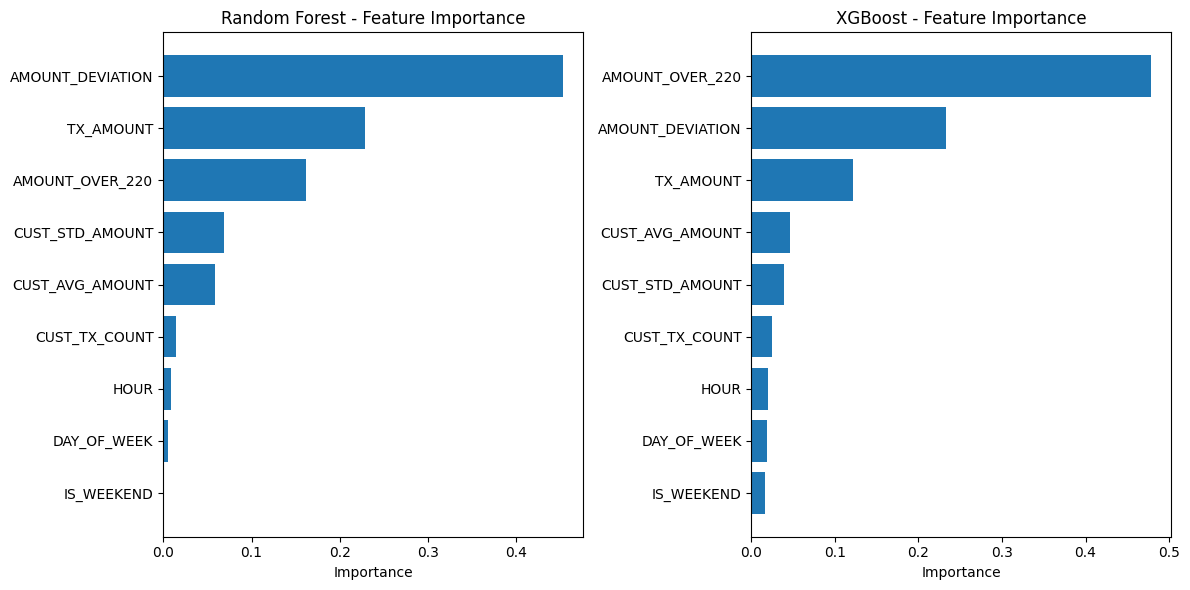

In [14]:

# FEATURE IMPORTANCE
def plot_feature_importance(results, feature_names):
    """Plot feature importance for all tree-based models using results dict from train_and_evaluate_models"""
    print("\n=== FEATURE IMPORTANCE ===")
    
    # Extract models from results dictionary
    models = {name: info['model'] for name, info in results.items()}
    
    plt.figure(figsize=(12, 6))
    
    for i, (name, model) in enumerate(models.items(), start=1):
        if hasattr(model, 'feature_importances_'):
            plt.subplot(1, len(models), i)
            
            # Get feature importance
            importance = model.feature_importances_
            feature_imp = pd.DataFrame({
                'feature': feature_names,
                'importance': importance
            }).sort_values('importance', ascending=True)
            
            # Plot
            plt.barh(feature_imp['feature'], feature_imp['importance'])
            plt.title(f'{name} - Feature Importance')
            plt.xlabel('Importance')
    
    plt.tight_layout()
    plt.show()

# ✅ Correct usage
# results = train_and_evaluate_models(X_train, y_train, X_test, y_test)
plot_feature_importance(results, feature_names=X_train.columns)


In [15]:
import joblib

# save the best performing model
def save_best_model(results):
    print("\n🔍 Finding the best performing model...")

    # pick model with highest AUC
    best_model_name, best_result = max(results.items(), key=lambda x: x[1]['auc'])
    best_model = best_result['model']

    print(f"\n🏆 BEST MODEL: {best_model_name} (AUC: {best_result['auc']:.4f})")

    # save best model
    joblib.dump(best_model, 'best_fraud_model_1.pkl')
    print("✅ Best model saved as 'best_fraud_model_1.pkl'")

    return best_model
best_model = save_best_model(results)


🔍 Finding the best performing model...

🏆 BEST MODEL: XGBoost (AUC: 0.6673)
✅ Best model saved as 'best_fraud_model_1.pkl'
